In [109]:
import sys
import os

# This adds the parent directory (root) to the python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [110]:
# load data
import pandas as pd

df = pd.read_csv("../data/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [111]:
# overview
import numpy as np

print(f"total: {df.shape[0]}")
print(f"unique categorical values: {df["is_duplicate"].unique()}")
print(f"class distribution: {df["is_duplicate"].value_counts()}")
print(f"mean: {df["is_duplicate"].mean():.3}")
print(f"standard deviation: {df["is_duplicate"].std():.3}")
print(f"missing: question1={df["question1"].isnull().sum()}, question2={df["question2"].isnull().sum()}")
print(f"duplicates: {df.duplicated().sum()}")
qid = pd.Series(df["qid1"].tolist() + df["qid2"].tolist())
print(f"unique questions: {np.unique(qid).shape[0]}")
x = qid.value_counts() > 1
print(f"repeated questions: {x[x].shape[0]}")
print("data types: ")
print(df.dtypes)

total: 404290
unique categorical values: [0 1]
class distribution: is_duplicate
0    255027
1    149263
Name: count, dtype: int64
mean: 0.369
standard deviation: 0.483
missing: question1=1, question2=2
duplicates: 0
unique questions: 537933
repeated questions: 111780
data types: 
id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object


In [112]:
# can drop missing values since only 3
df.dropna(inplace=True)
print(df.isnull().sum().sum())

0


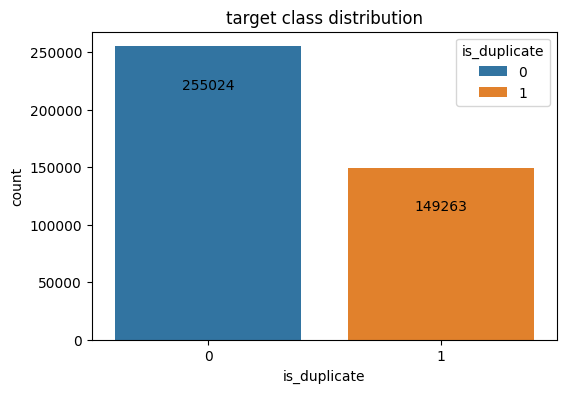

In [113]:
# plot to visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x="is_duplicate", hue="is_duplicate", palette={0: "tab:blue", 1: "tab:orange"})
ax.bar_label(ax.containers[0], padding=-33)
ax.bar_label(ax.containers[1], padding=-33)
plt.title("target class distribution")
plt.xlabel("is_duplicate")
plt.ylabel("count")
plt.show()

In [114]:
import re
from bs4 import BeautifulSoup
import inflect
from scripts.utils.loader import load_contractions

p = inflect.engine()
contractions = load_contractions()

def preprocess(text):
    text = str(text).lower()
    # remove html tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # expand contractions
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    # removes everything except letters
    text = re.sub(r"[^a-z\s]", " ", text)
    return " ".join(text.split())

df["question1"] = df["question1"].apply(preprocess)
df["question2"] = df["question2"].apply(preprocess)

In [115]:
# count of words
df["q1_len"] = df["question1"].apply(lambda x: len(str(x).split()))
df["q2_len"] = df["question2"].apply(lambda x: len(str(x).split()))

# common words
df["common_words"] = df.apply(lambda x: len(set(str(x["question1"]).lower().split()) & set(str(x["question2"]).lower().split())), axis=1)

# unique words
df["unique_words"] = df.apply(lambda x: len(set(str(x["question1"]).lower().split()) | set(str(x["question2"]).lower().split())), axis=1)

# word share
df["word_share"] = ((df["common_words"] / df["unique_words"]) * 100).round(2)

# first word equal or not?
df["first_word"] = df.apply(lambda x: 1 if str(x["question1"]).split()[:1] == str(x["question2"]).split()[:1] else 0, axis=1)

# last word equal or not?
df["last_word"] = df.apply(lambda x: 1 if str(x["question1"]).split()[-1:] == str(x["question2"]).split()[-1:] else 0, axis=1)

# question frequency in the whole dataset
qid_counts = qid.value_counts()
df["q1_freq"] = df["qid1"].map(qid_counts)
df["q2_freq"] = df["qid2"].map(qid_counts)

In [116]:
def feature_statistics(df):
	features = df.drop(columns=["id", "qid1", "qid2", "question1", "question2"]).columns

	stats_list = []

	for col in features:
		data = df[col]

		# calculate inter quartile range
		q1 = data.quantile(0.25)
		q3 = data.quantile(0.75)
		iqr = q3 - q1

		stats_list.append({
			"feature": col,
			"mean": data.mean(),
			"median": data.median(),
			"mode": data.mode()[0],
			"min": data.min(),
			"max": data.max(),
			"range": data.max() - data.min(),
			"variance": data.var(),
			"std Dev": data.std(),
			"iqr": iqr,
			"skewness": data.skew(),
			"kurtosis": data.kurtosis()
		})

	return stats_list

In [117]:
stats_list = feature_statistics(df)
# download the statistical data
stats_df = pd.DataFrame(stats_list)
stats_df.to_csv("../data/feature_statistics.csv", index=False)
stats_df.head(20)

,feature,mean,median,mode,min,max,range,variance,std Dev,iqr,skewness,kurtosis
0,is_duplicate,0.369201,0.00,0.0,0.0,1.0,1.0,0.232892,0.482589,1.00,0.542076,-1.706162
1,q1_len,10.976702,10.00,8.0,0.0,127.0,127.0,29.751521,5.454496,6.00,1.931748,7.003595
2,q2_len,11.216448,10.00,8.0,0.0,244.0,244.0,40.331355,6.350697,6.00,4.196475,79.217222
3,common_words,4.982060,5.00,4.0,0.0,38.0,38.0,9.645026,3.105644,3.00,1.292249,3.508106
4,unique_words,15.994675,14.00,11.0,0.0,139.0,139.0,58.286865,7.634583,8.00,1.571284,4.962693
5,word_share,37.192981,33.33,50.0,0.0,100.0,100.0,604.676064,24.590162,36.55,0.566448,-0.544489
6,first_word,0.513744,1.00,1.0,0.0,1.0,1.0,0.249812,0.499812,1.00,-0.054997,-1.996985
7,last_word,0.320520,0.00,0.0,0.0,1.0,1.0,0.217787,0.466677,1.00,0.769188,-1.408358
8,q1_freq,3.811631,1.00,1.0,1.0,157.0,156.0,43.690090,6.609848,2.00,5.128904,50.215886
9,q2_freq,4.030983,1.00,1.0,1.0,157.0,156.0,61.709824,7.855560,2.00,6.563506,76.620446


In [118]:
# features with outliers or high range
uncapped_cols = ["q1_len", "q2_len"]
for col in uncapped_cols:
	upper_limit = df[col].quantile(0.99)
	df[col] = df[col].clip(upper=upper_limit)

# features with high skewness
skewed_cols = ["q1_freq", "q2_freq"]
for col in skewed_cols:
    # log transformation
    df[col] = np.log1p(df[col])

In [119]:
# length based
df["len_sum"] = df["q1_len"] + df["q2_len"]
df["len_diff"] = abs(df["q1_len"] - df["q2_len"])
df["len_mean"] = df["len_diff"] / df["len_sum"]

# sum of frequencies: how popular is the pair?
df["freq_sum"] = df["q1_freq"] + df["q2_freq"]

# difference of frequencies: is one question more popular than the other
df["freq_diff"] = abs(df["q1_freq"] - df["q2_freq"])

In [120]:
stats_list = feature_statistics(df)
# download the statistical data
stats_df = pd.DataFrame(stats_list)
stats_df.to_csv("../data/feature_statistics.csv", index=False)
stats_df.head(20)

,feature,mean,median,mode,min,max,range,variance,std Dev,iqr,skewness,kurtosis
0,is_duplicate,0.369201,0.000000,0.000000,0.000000,1.000000,1.000000,0.232892,0.482589,1.000000,0.542076,-1.706162
1,q1_len,10.913663,10.000000,8.000000,0.000000,29.000000,29.000000,26.569927,5.154602,6.000000,1.368508,1.909367
2,q2_len,11.116615,10.000000,8.000000,0.000000,33.000000,33.000000,32.415231,5.693438,6.000000,1.586897,2.695629
3,common_words,4.982060,5.000000,4.000000,0.000000,38.000000,38.000000,9.645026,3.105644,3.000000,1.292249,3.508106
4,unique_words,15.994675,14.000000,11.000000,0.000000,139.000000,139.000000,58.286865,7.634583,8.000000,1.571284,4.962693
5,word_share,37.192981,33.330000,50.000000,0.000000,100.000000,100.000000,604.676064,24.590162,36.550000,0.566448,-0.544489
6,first_word,0.513744,1.000000,1.000000,0.000000,1.000000,1.000000,0.249812,0.499812,1.000000,-0.054997,-1.996985
7,last_word,0.320520,0.000000,0.000000,0.000000,1.000000,1.000000,0.217787,0.466677,1.000000,0.769188,-1.408358
8,q1_freq,1.198992,0.693147,0.693147,0.693147,5.062595,4.369448,0.511456,0.715161,0.693147,1.648253,2.219780
9,q2_freq,1.192742,0.693147,0.693147,0.693147,5.062595,4.369448,0.563651,0.750767,0.693147,1.703745,2.356345


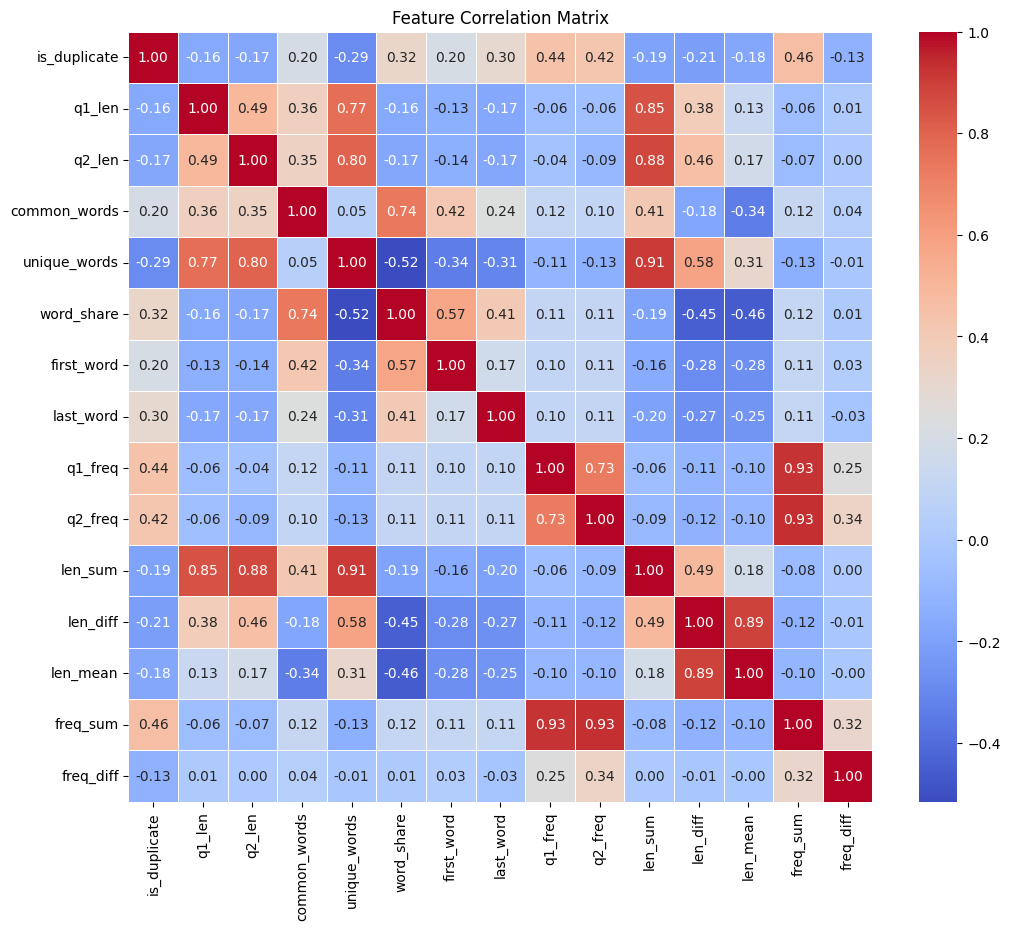

In [121]:
features = df.drop(columns=["id", "qid1", "qid2", "question1", "question2"]).columns

corr_matrix = df[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [122]:
cols_to_drop = ["q1_len", "q2_len", "common_words", "unique_words", "len_sum", "len_mean", "q1_freq", "q2_freq"]
df = df.drop(columns=cols_to_drop)

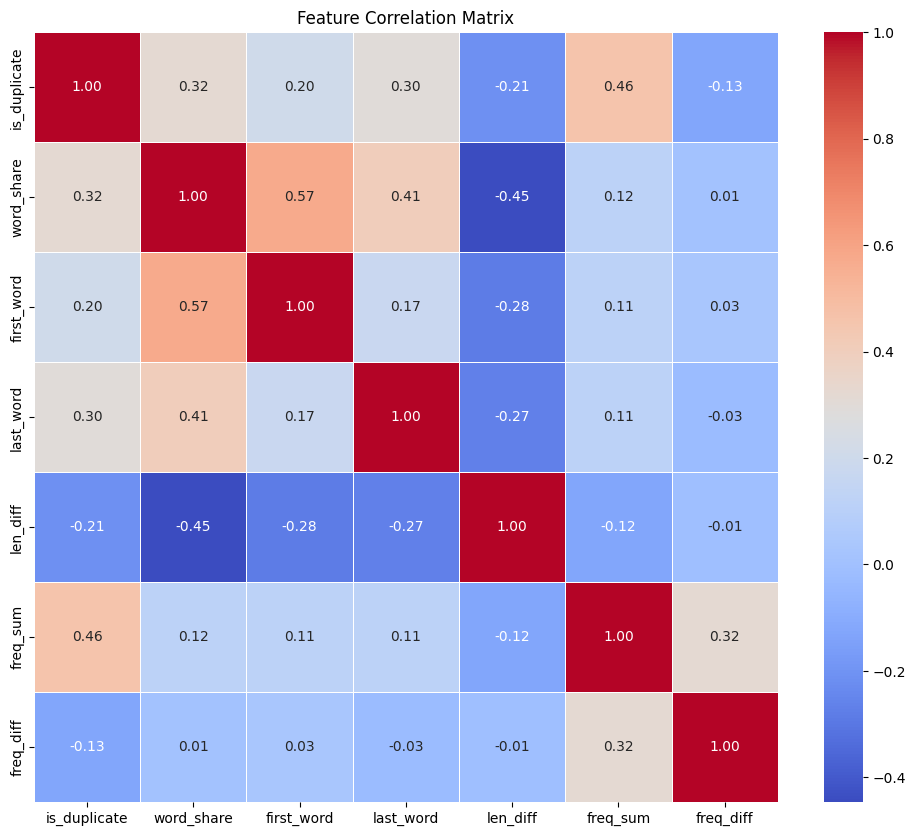

In [123]:
features = df.drop(columns=["id", "qid1", "qid2", "question1", "question2"]).columns

corr_matrix = df[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

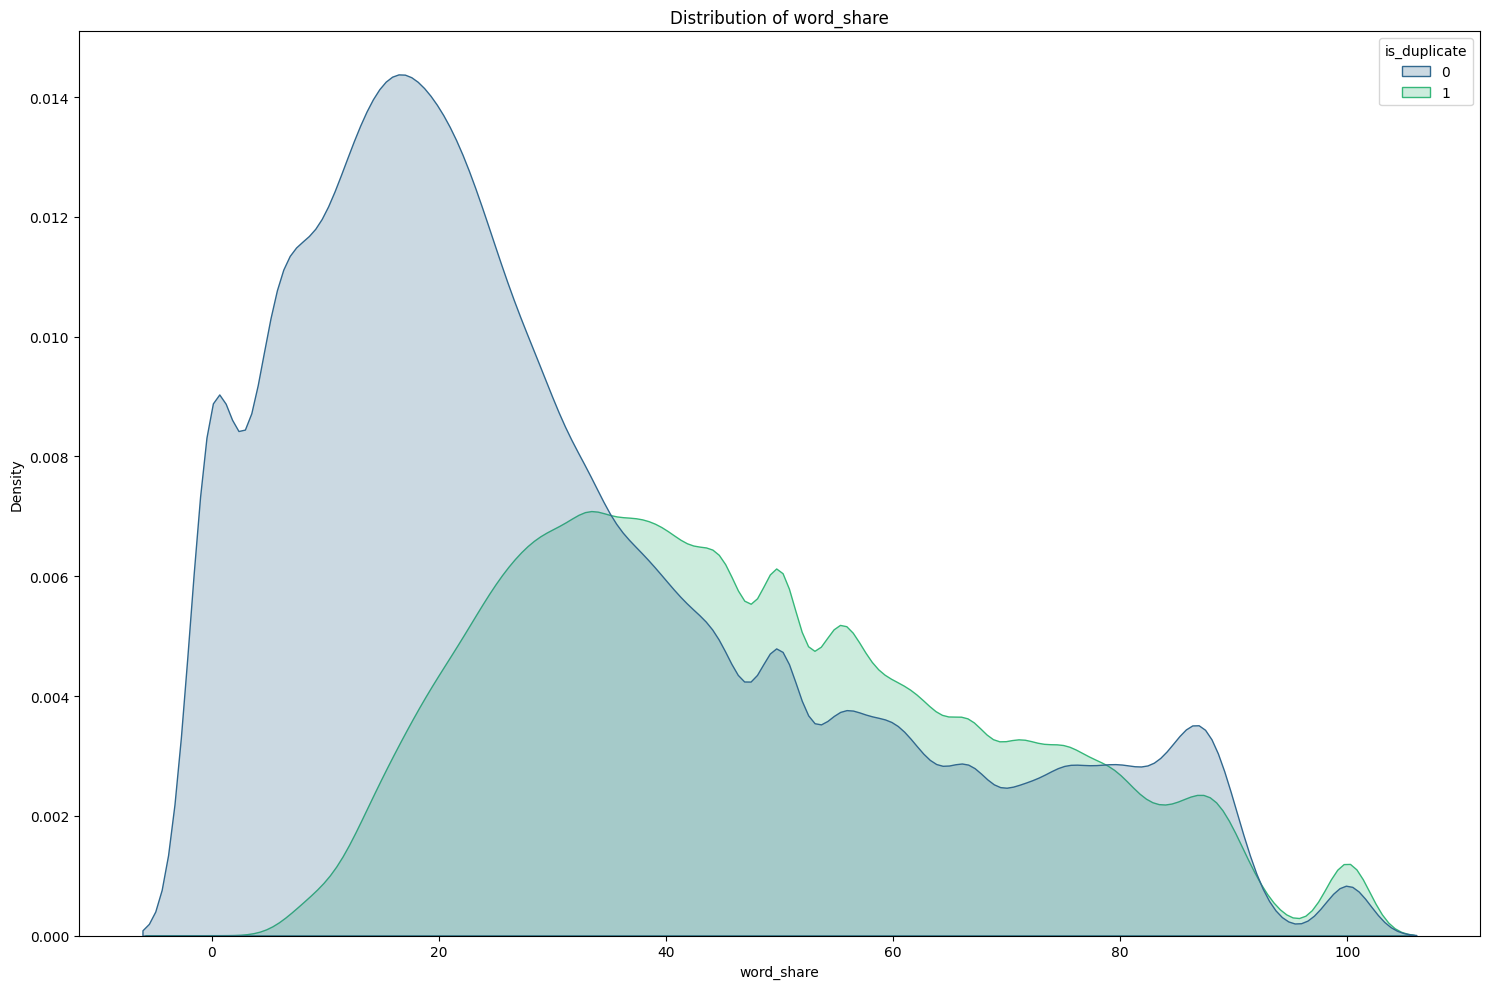

In [125]:
plt.figure(figsize=(15, 10))
sns.kdeplot(data=df, x="word_share", hue="is_duplicate", fill=True, palette="viridis")
plt.title(f"Distribution of word_share")

plt.tight_layout()
plt.show()

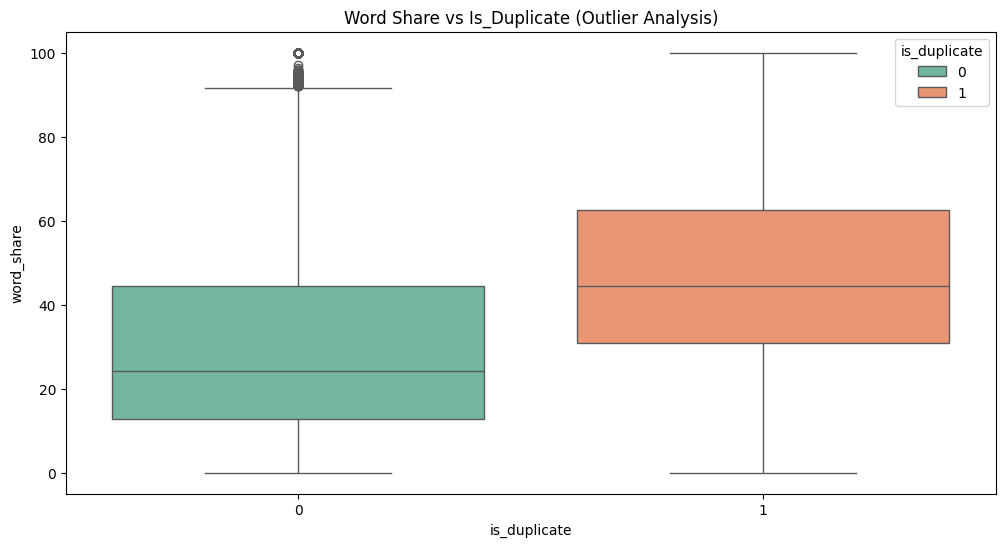

In [126]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="is_duplicate", y="word_share", palette="Set2", hue="is_duplicate")
plt.title("Word Share vs Is_Duplicate (Outlier Analysis)")
plt.show()